In [1]:
import numpy as np
import scipy as sp
import scipy.stats as stats
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import animation, rc
from IPython.display import HTML

# import pymc3 as pm
# import theano
# import theano.tensor as tt
# from sampled import sampled

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C, WhiteKernel
from functools import wraps

import seaborn as sns
import pandas as pd

%matplotlib inline

In [2]:
mpl.rcParams['figure.dpi'] = 120
# To automatically animate in a jupyter notebook
# rc('animation', html='html5')
rc('animation', html='jshtml')

# Bayesian Optimization with Tunable Precision

This notebook aims to outline the basics behind finding minima of noisy functions that are computationally difficult to evaluate.
In particular, we are interested in picking both the input locations and the amount of CPU time dedicated to the precision at each input wisely so as to get a good estimate of the minimum with the least computational effort.
Bayesian optimization (BO) is a neat tool for optimizing functions which uses Gaussian processes (GPs) in intermediate steps to infer the best input location to try next.
BO has the benefit of not getting stuck in local minima, but not as much effort has been devoted to simulators that are inherently noisy, and in particular to simulators which have tunable precision, with the tradeoff being the computation time required.
The two most helpful papers on BO that I have found for this purpose has been [a review article by Peter Frazier](http://arxiv.org/abs/1807.02811) which led me to [Picheny et al.](https://www.tandfonline.com/doi/full/10.1080/00401706.2012.707580)
The current iteration of this notebook implements the basic constant allocation in Picheny et al. as a proof of principle.

## Reproducing Picheny et al.

Picheny et al. have some figures that shouldn't be too difficult to make ourselves. Once we have the training points and have determined the interpolating GP, the necessary equations for choosing the "best" next point are actually quite simple, and only involve finding the maximum of the expected quantile improvement (EQI).

In [3]:
def beta_qn(beta, mean, sd):
    return mean + stats.norm.ppf(beta) * sd

def arg_beta_qn(beta, mean, sd):
    return np.argmin(beta_qn(beta, mean, sd))

def meanQ(sd_noise, beta, mean, sd):
    return mean + stats.norm.ppf(beta) * np.sqrt(sd_noise ** 2 * sd ** 2 / (sd ** 2 + sd_noise ** 2))

def sdQ(sd_noise, sd):
    return sd ** 2 / np.sqrt(sd ** 2 + sd_noise ** 2)

def eqi(sd_noise, beta, mean, sd, qn):
    sd_Q = sdQ(sd_noise, sd)
    m_Q = meanQ(sd_noise, beta, mean, sd)
    min_qn = np.min(qn)
    d = min_qn - m_Q
    # print(d, sd_Q)
    return d * stats.norm.cdf(d / sd_Q) + sd_Q * stats.norm.pdf(d / sd_Q)

Now let's make Figure 2 from Picheny et al.

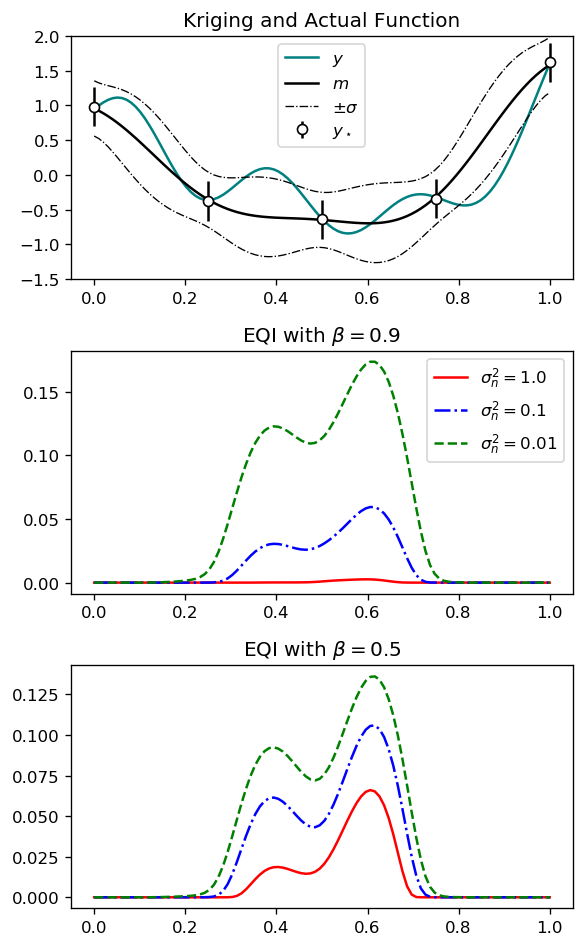

In [4]:
def fig2_func(x):
    return 0.5 * (np.sin(20*x) / (1 + x) + 3 * x**3 * np.cos(5*x) + 10 * (x - 0.5)**2 - 0.6)

np.random.seed(1)

fig2_sd = np.sqrt(0.02)
fig2_x_all = np.linspace(0, 1, 100)
fig2_x = np.linspace(0, 1, 5)
fig2_y_all = fig2_func(fig2_x_all)
fig2_y = fig2_func(fig2_x) + fig2_sd**2 * np.random.randn(fig2_x.size)


kernel = C(1.0, (0.01, 10)) * RBF(0.19, (0.2, 0.3)) + WhiteKernel(noise_level=fig2_sd**2, noise_level_bounds=(fig2_sd**2, fig2_sd**2))
gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=9, #optimizer=None
                             )
gp.fit(fig2_x[:, None], fig2_y)
y_pred, cov_pred = gp.predict(fig2_x_all[:, None], return_cov=True)
sd_pred = np.sqrt(np.diag(cov_pred))

fig, axes = plt.subplots(3, 1, figsize=(5, 8))
axes[0].plot(fig2_x_all, fig2_y_all, c='teal', label=r'$y$')
axes[0].plot(fig2_x_all, y_pred, c='k', label=r'$m$')
axes[0].plot(fig2_x_all, y_pred + 2*sd_pred, c='k', ls='-.', lw=0.8, label=r'$\pm \sigma$')
axes[0].plot(fig2_x_all, y_pred - 2*sd_pred, c='k', ls='-.', lw=0.8)
axes[0].errorbar(fig2_x, fig2_y, 2*fig2_sd, c='k', ls='', marker='o', mfc='white', label=r'$y_\star$');
axes[0].set_ylim([-1.5, 2])
axes[0].legend()
axes[0].set_title('Kriging and Actual Function')

for i, beta in enumerate([0.9, 0.5]):
    for j, var_n in enumerate([1.0, 0.1, 0.01]):
        qn = beta_qn(beta, fig2_y, fig2_sd)
        eqi_val = eqi(np.sqrt(var_n), beta, y_pred, sd_pred, qn)
        axes[i+1].plot(fig2_x_all, eqi_val, ls=['-', '-.', '--'][j], c=['r', 'b', 'g'][j],
                       label=r'$\sigma_n^2 = {}$'.format(var_n))
    axes[i+1].set_title(r'EQI with $\beta = {}$'.format(beta))
axes[1].legend();
fig.tight_layout();

Eh, more or less the same as Figure 2.
The exact form is dependent on the GP that was estimated from the random data, neither of which were given in the paper.

## Posterior Predictive Distributions for Minima

Once fitting a few datapoints with a GP, we can make a best guess for where its minimum is located by using the posterior predictive distribution, that is $\text{pr}(y | x_\star, y_\star)$, where $y$ are the output of the function at unseen locations, and $x_\star$ and $y_\star$ are the points where we have run the simulator to fit our GP.
Because $\text{pr}(y | x_\star, y_\star)$ encapsulates all that we know about the function as is itself a probability distribution, we can draw many sample curves from it and find where the minimum is located for each sample.
This then provides a distribution for the location and value of the minimum.

Let's start with a simple noisy quadratic that we would like to minimize.

In [5]:
def f(x, sd):
    x = x.ravel()
    scale = sd
    err = stats.norm(np.zeros_like(x), scale=scale+1e-15).rvs()
    return x ** 2 + err

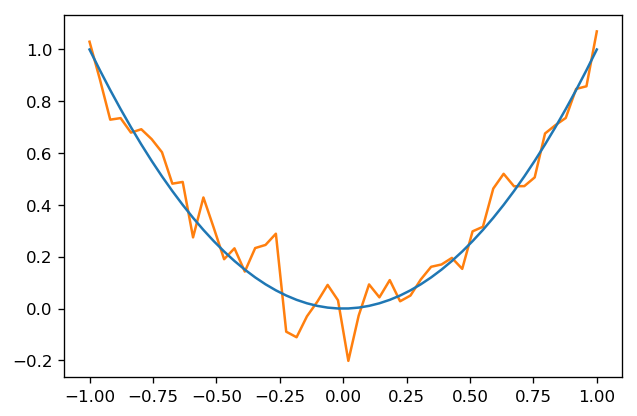

In [6]:
np.random.seed(1)
x_all = np.linspace(-1, 1, 50)
f_all = f(x_all, sd=0)
y_all = f(x_all, sd=0.1)

plt.plot(x_all, f_all, zorder=20);
plt.plot(x_all, y_all);

Given a few points, we can interpolate and guess where the minimum is

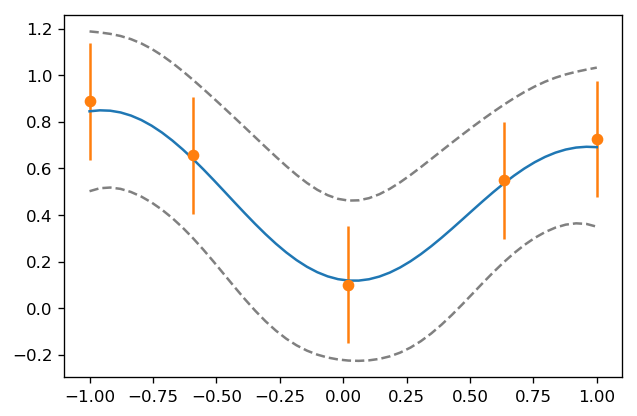

In [7]:
# x_idx = np.array([0, 50, 100, 150, 199])
x_idx = np.array([0, 10, 25, 40, 49])
x = x_all[x_idx]
sd = 0.25
y = f(x, sd=sd)

kernel = C(1.0, (1e-3, 1e3)) * RBF(0.5, (0.1, 10.)) + WhiteKernel(noise_level=sd**2)
gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=9, optimizer=None)

# Fit to data using Maximum Likelihood Estimation of the parameters
gp.fit(x[:, None], y)
y_pred, cov_pred = gp.predict(x_all[:, None], return_cov=True)
sd_pred = np.sqrt(np.diag(cov_pred))

plt.plot(x_all, y_pred);
plt.plot(x_all, y_pred - sd_pred, ls='--', c='gray');
plt.plot(x_all, y_pred + sd_pred, ls='--', c='gray');
plt.errorbar(x, y, sd, ls='', marker='o');

The code for visualizing a probability density for the minimum is given here, and applied below.

In [8]:
def minimum_pdf(mean, cov, n=5000):
    gp = stats.multivariate_normal(mean=mean, cov=cov)
    samples = gp.rvs(n)
    min_idxs = np.argmin(samples, axis=1)
    # print('shapes', samples.shape, min_idxs.shape)
    min_x = x_all[min_idxs]
    min_y = np.zeros_like(min_x)
    for i, arg in enumerate(min_idxs):
        min_y[i] = samples[i, min_idxs[i]]
    return min_x, min_y

def minimum_pdf_plot(X, mean, cov, n=5000, xy_true=None):
    x, y = minimum_pdf(mean, cov, n)
    
    
    xstats = stats.describe(x)
    ystats = stats.describe(y)
    kwargs = dict(c='k', lw=0.5)
    sd_x = np.sqrt(xstats.variance)
    sd_y = np.sqrt(ystats.variance)
    
    
    d = pd.DataFrame({'x': x, 'y': y})
    g = sns.jointplot("x", "y", data=d,
                      kind="kde", space=0, color='k', shade=False, label='pr(min)',
                      joint_kws={'color': 'k'}  # For the label
                     )
    xlim = g.ax_joint.get_xlim()
    ylim = g.ax_joint.get_ylim()

    # g.ax_joint.axvline(xstats.mean - sd_x, **kwargs)
    # g.ax_joint.axvline(xstats.mean + sd_x, **kwargs)
    # g.ax_marg_x.axvline(xstats.mean - sd_x, **kwargs)
    # g.ax_marg_x.axvline(xstats.mean + sd_x, **kwargs)

    # g.ax_joint.axhline(ystats.mean - sd_y, **kwargs)
    # g.ax_joint.axhline(ystats.mean + sd_y, **kwargs)
    # g.ax_marg_y.axhline(ystats.mean - sd_y, **kwargs)
    # g.ax_marg_y.axhline(ystats.mean + sd_y, **kwargs)

    transx = mpl.transforms.blended_transform_factory(
        g.ax_joint.transData, g.ax_joint.transAxes)
    transy = mpl.transforms.blended_transform_factory(
        g.ax_joint.transAxes, g.ax_joint.transData)
    g.ax_joint.fill_betweenx([0, 1], xstats.mean - sd_x, xstats.mean + sd_x, transform=transx,
                             alpha=0.2, color='b', zorder=0, label=r'68%')
    g.ax_joint.fill_between([0, 1], ystats.mean - sd_y, ystats.mean + sd_y, transform=transy, alpha=0.2, color='b', zorder=0)
    
    if xy_true is not None:
        g.ax_joint.scatter(xy_true[0], xy_true[1], marker='x', c='r', label='True')
        g.ax_marg_x.axvline(xy_true[0], c='r')
        g.ax_marg_y.axhline(xy_true[1], c='r')
    
    g.ax_joint.set_xlim(xlim)
    g.ax_joint.set_ylim(ylim)
    
    sd = np.sqrt(np.diag(cov))
    g.ax_joint.plot(X, mean, label=r'$y$');
    g.ax_joint.plot(X, mean - sd, ls='--', c='gray', label=r'$y\pm\sigma$');
    g.ax_joint.plot(X, mean + sd, ls='--', c='gray');
    g.ax_joint.legend()
    return g
    

/Users/jordanmelendez/anaconda/envs/python-3.6/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


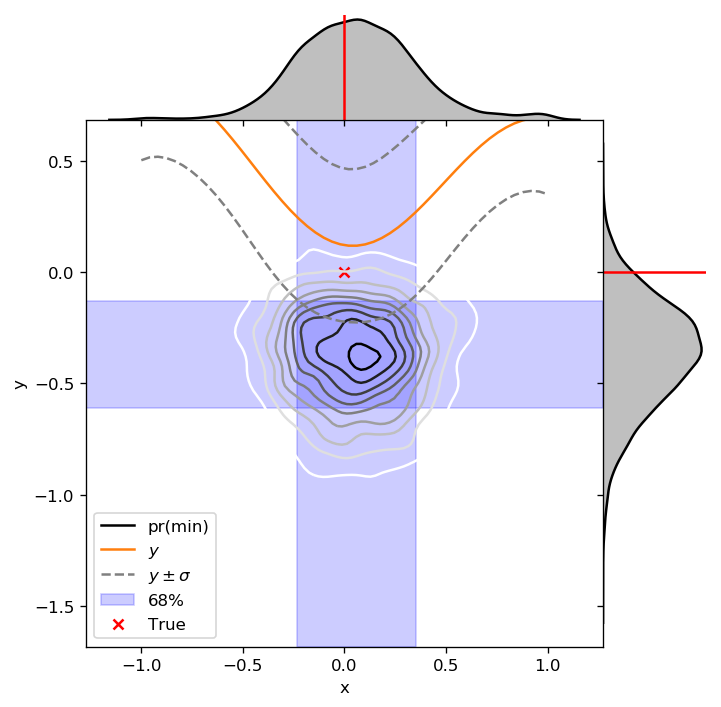

In [9]:
g = minimum_pdf_plot(x_all, y_pred, cov_pred, 5000, (0,0))

It seems to do ok, but always errs on the side of underestimating the minimum. Maybe I'm doing something wrong.

## Sequential Design via Bayesian Optimization

Sequential design is a way to choose the next set of data we collect based on data that we've already seen, which can lead to much better predictions in the end.
To allocate resources effectively, we need to understand the relationship between the precision (or standard deviation $\sigma_n$) of the output and the time required for one output from the code. Let's make something up for now, using
$$
    \sigma_n^2(t) = \frac{C}{t}
$$
for some constant $C$, which is an appropriate for Monte Carlo simulators.
We will take $C=1$ for now, but in general it must be estimated by running the code.

In [10]:
def prec_from_time(time):
    return time

def sd_from_time(time):
    return 1. / np.sqrt(time)

def time_from_sd(sd):
    return 1. / sd**2

In [11]:
# H, xed, yed = np.histogram2d(x_min_new, y_min_new, bins=30)
# xgrid, ygrid = np.meshgrid(xed[:-1], yed[:-1])
# plt.contour(xgrid, ygrid, H.T);

In [12]:
def basic_predict(X, y, Xnew, mean_func, cov_func, noise, return_std=False, return_cov=False):
    """Makes a GP interpolant that does not update hyperparameters but can accept non-white noise"""
    m_old = mean_func(X)
    m_new = mean_func(Xnew)
    K_oo = cov_func(X, X) + np.diag(noise**2)
    chol = np.linalg.cholesky(K_oo)
    K_on = cov_func(X, Xnew)
    K_no = K_on.T
    K_nn = cov_func(Xnew, Xnew)

    mfilter = np.dot(K_no, sp.linalg.cho_solve((chol, True), (y - m_old).T)).T
    m_pred = m_new + mfilter
    half_quad = sp.linalg.solve_triangular(chol, K_on, lower=True)
    K_pred = K_nn - np.dot(half_quad.T, half_quad)
    if return_std:
        return m_pred, np.sqrt(np.diag(K_pred)+1e-17)
    if return_cov:
        return m_pred, K_pred
    return m_pred

Below is all the code that does the Bayesian optimization. The details aren't important unless you're into that sort of thing. Right now only the "constant allocation" version is implemented.

In [13]:
def required_sd(sd_current, sd_desired):
    v1 = sd_current ** 2
    v2 = sd_desired ** 2
    return np.sqrt(v1 * v2 / (v1 - v2))

def equivalent_sd(sd1, sd2):
    v1 = sd1 ** 2
    v2 = sd2 ** 2
    return np.sqrt(v1 * v2 / (v1 + v2))

def equivalent_y(y1, sd1, y2, sd2):
    v1 = sd1 ** 2
    v2 = sd2 ** 2
    return (y1 / v1 + y2 / v2) / (1. / v1 + 1. / v2) 

class EQIOpt:
    
    def __init__(self, X, mean, kernel, beta, budget, pred_func, sd_noise_func, time_func):
        self.X = X
        self.nx = len(self.X)
        self.y = np.zeros(self.nx)
        self.active = None
        self.X = X
        self.init_budget = budget
        self.mean = mean
        self.kernel = kernel
        self.beta = beta
        self.pred_func = pred_func
        self.sd_noise_func = sd_noise_func
        self.time_func = time_func
    
    def initial_design(self, X_idx, budget_per_idx):
        self.idx0 = X_idx
        self.budget_per_idx0 = budget_per_idx
        self.cumulative_budgets0 = np.zeros(self.nx, dtype=float)
        self.cumulative_budgets0[X_idx] = budget_per_idx
        self.sd_noise0 = np.zeros(self.nx, dtype=float)
        self.sd_noise0[X_idx] = self.sd_noise_func(budget_per_idx)
        self.active0 = np.zeros(self.nx, dtype=bool)
        self.active0[X_idx] = True
        self.y0 = np.zeros(self.nx, dtype=float)
        self.y0[X_idx] = self.pred_func(self.X[X_idx], sd=self.sd_noise0[X_idx])
        self.budget0 = self.init_budget - np.sum(self.cumulative_budgets0[X_idx])  
    
    def generator(self, budget_per_iter):
        # Reset:
        cumulative_budgets = self.cumulative_budgets0.copy()
        sd_noise = self.sd_noise0.copy()
        active = self.active0.copy()
        y = self.y0.copy()
        X = self.X.copy()
        budget = self.budget0
        
        one = np.ones(self.nx)
        idx = None
        x_new = y_new = sd_new = None
        
        while budget > 0:
            # After first pass, update existing points or add new ones
            if idx is not None:
                x_new = X[idx]
                if budget_per_iter > budget:
                    budget_per_iter = budget
                sd_new = self.sd_noise_func(budget_per_iter)
                y_new = self.pred_func(x_new, sd=sd_new)
                if active[idx]:
                    y_equiv = equivalent_y(y[idx], sd_noise[idx], y_new, sd_new)
                    eq_sd = equivalent_sd(sd_noise[idx], sd_new)
                    sd_noise[idx] = eq_sd
                    y[idx] = y_equiv
                else:
                    sd_noise[idx] = sd_new
                    active[idx] = True
                    y[idx] = y_new
                
                cumulative_budgets[idx] += budget_per_iter
                budget -= budget_per_iter
            
            # Fit GP to data
            y_pred, sd_pred = basic_predict(
                X[active], y[active], X, mean_func=self.mean, cov_func=self.kernel,
                noise=sd_noise[active], return_std=True)
            
            # Start looking for next point to try if there is budget left
            if budget > 0:
                
                sd_noise_all_budget = self.sd_noise_func(budget) * one  # myopic strategy

                # Handle repeated points
                sd_noise_desired = self.sd_noise_func(cumulative_budgets + budget)
                sd_noise_required = required_sd(sd_noise, sd_noise_desired)
                sd_noise_all_budget[active] = sd_noise_required[active]

                # Find best point to try next
                qn = beta_qn(self.beta, y[active], sd_noise[active])
                eqi_val = eqi(sd_noise_all_budget, self.beta, y_pred, sd_pred, qn)
                idx = np.argmax(eqi_val, axis=None)

            yield {
                'budget': budget,
                'active': active.copy(),
                'eqi': eqi_val,
                'y': y.copy(),
                'y_pred': y_pred,
                'sd_pred': sd_pred,
                'sd_noise': sd_noise.copy(),
                'x_new': x_new,
                'sd_new': sd_new,
                'idx': idx
            }

    def constant_allocation(self, budget_per_iter):
        dicts = [d for d in self.generator(budget_per_iter)]
        arr = np.recarray(
            (len(dicts), self.nx),
            dtype=[
                ('budget', float),
                ('active', bool),
                ('eqi', float),
                ('y', float),
                ('y_pred', float),
                ('sd_pred', float),
                ('sd_noise', float),
                ('x_new', float),
                ('sd_new', float),
                ('idx', int)
            ])
        for i, d in enumerate(dicts):
            for name in d.keys():
                arr[name][i] = d[name]
        return arr
    
    def plot_updates(self, arr):
        for d in arr:
            budget = d['budget'][0]
            active = d['active']
            eqi_val = d['eqi']
            y = d['y']
            y_pred = d['y_pred']
            sd_pred = d['sd_pred']
            sd_noise = d['sd_noise']
            idx = d['idx'][0]
            X = self.X

            fig, axes = plt.subplots(1, 2, figsize=(10, 4))
            axes[0].errorbar(X[active], y[active], sd_noise[active], ls='', marker='o')
            axes[0].axvline(X[idx], 0, 1, c='y', ls='--', lw=0.7)

            axes[0].plot(X, y_pred)
            axes[0].plot(X, y_pred - sd_pred, c='gray', ls='--')
            axes[0].plot(X, y_pred + sd_pred, c='gray', ls='--')
            axes[0].set_title('Predictions')
            axes[0].set_xlabel('x')
            axes[0].grid(axis='y')
            axes[1].plot(X, eqi_val)
            axes[1].axvline(X[idx], 0, 1, c='y', ls='--', lw=0.7)
            axes[1].set_title(r'EQI($\beta={}$): Remaining budget = {}'.format(self.beta, budget))
            axes[1].set_xlabel('x')
            fig.tight_layout()

        return fig, axes
    
    def animation(self, arr):
        fig, axes = plt.subplots(1, 2, figsize=(8, 4))
        # the x coords of this transformation are data, and the
        # y coord are axes
        trans0 = mpl.transforms.blended_transform_factory(
            axes[0].transData, axes[0].transAxes)
        trans1 = mpl.transforms.blended_transform_factory(
            axes[1].transData, axes[1].transAxes)

        # For function plot
        bars, = axes[0].plot([], [], ls='', marker='o', c='C0')
        vbars = [axes[0].plot([], [], c='C0')[0] for i in range(self.nx)]
        vline, = axes[0].plot([], [], c='y', ls='--', lw=0.7, transform=trans0)
        pred_line, = axes[0].plot([], [], c='C1')
        sdl_line, = axes[0].plot([], [], c='gray', ls='--')
        sdu_line, = axes[0].plot([], [], c='gray', ls='--')

        # For eqi plot
        eqi_line, = axes[1].plot([], [])
        meqi_line, = axes[1].plot([], [], c='y', ls='--', lw=0.7, transform=trans1)
        
        # Format them
        axes[0].set_title('Predictions')
        axes[0].set_xlabel('x')
        axes[0].grid(axis='y')
        xmin = self.X.min()
        xmax = self.X.max()
        axes[0].set_xlim([xmin-0.1*abs(xmin), xmax+0.1*abs(xmax)])
        axes[1].set_xlim([xmin-0.1*abs(xmin), xmax+0.1*abs(xmax)])
        axes[1].set_xlabel('x')

        # ds = [d for d in self.generator(budget_per_iter)]
        # min_y = np.min([d['y'] - d['sd_noise'] for d in ds])
        # max_y = np.max([d['y'] + d['sd_noise'] for d in ds])
        min_y = np.min(arr['y'] - arr['sd_noise'])
        max_y = np.max(arr['y'] + arr['sd_noise'])
        axes[0].set_ylim([min_y, max_y])
        
        indexes = np.arange(self.nx)
        X = self.X
        
        def init():
            return (bars, pred_line, sdl_line, sdu_line, eqi_line, meqi_line, vline, *vbars)
        
        def animate(i):
            d = arr[i]
            budget = d['budget'][0]
            active = d['active']
            eqi_val = d['eqi']
            y = d['y']
            y_pred = d['y_pred']
            sd_pred = d['sd_pred']
            sd_noise = d['sd_noise']
            idx = d['idx'][0]
            
            axes[1].set_title(r'EQI($\beta={}$): Remaining budget = {}'.format(self.beta, budget))
            
            # Because I can't get errorbar to animate correctly
            bars.set_data(X[active], y[active])
            for i in indexes[active]:
                vbars[i].set_data([X[i], X[i]], [y[i]-sd_noise[i], y[i]+sd_noise[i]])

            vline.set_data([X[idx], X[idx]], [0, 1])
            pred_line.set_data(X, y_pred)
            sdl_line.set_data(X, y_pred - sd_pred)
            sdu_line.set_data(X, y_pred + sd_pred)
            eqi_line.set_data(X, eqi_val)
            axes[1].set_ylim([0, 1.1*max(eqi_val)])
            meqi_line.set_data([X[idx], X[idx]], [0, 1])
            return (bars, pred_line, sdl_line, sdu_line, eqi_line, meqi_line, vline, *vbars)
        
        fig.tight_layout()
        # call the animator. blit=True means only re-draw the parts that have changed.
        anim = animation.FuncAnimation(fig, animate, init_func=init, frames=len(arr), interval=1000, blit=True)
        plt.close();  # Don't show the static plot made here, only the anim
        return anim


Now the good stuff: the blue points are the underlying difficult-to-evaluate code at a given level of precision, and the interpolator is the GP given those points with gray 68% error bands. The right plot is the expected quantile improvement (EQI), which is maximized to pick the best $x$ location to try next. We repeat this until we run out of computational budget.
The figure below should animate and show a proof of principle.

In [14]:
kernel = C(1.0, (1e-3, 1e3)) * RBF(1, (0.1, 10.))
budget_init_opt = 15
budget_opt = 15
opt = EQIOpt(X=x_all[:, None], mean=lambda x: 0., kernel=kernel, beta=0.5, budget=200,
             pred_func=f, sd_noise_func=sd_from_time, time_func=time_from_sd)
np.random.seed(1)
opt.initial_design(x_idx, budget_init_opt)
np.random.seed(1)
bopt_arr = opt.constant_allocation(budget_opt)
anim = opt.animation(bopt_arr)
anim

The posterior for the minimum after Bayesian optimization is given here.

/Users/jordanmelendez/anaconda/envs/python-3.6/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


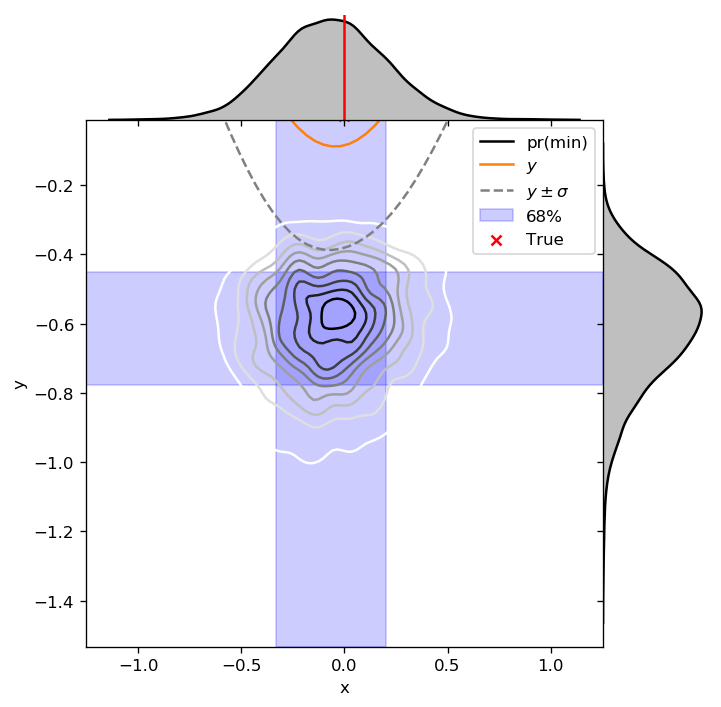

In [15]:
minimum_pdf_plot(opt.X.ravel(), bopt_arr[-1]['y_pred'], np.diag(bopt_arr[-1]['sd_pred']), 5000, (0,0))

In [16]:
# fig, axes = opt.plot_updates(bopt_arr)

## Todo

I want to let the GP update its hyperparameters based on the data that it's seen so far during the Bayesian optimization.
I also want to implement the "online allocation" method, and apply this to real data!